In [1]:
#!/usr/bin/env python
# ────────────────────────────────────────────────────────────────
# deep_vs_shallow_boot.py
#   - 2100–3000 it の Elo を平均
#   - 比 (deep/shallow) と 差 (deep-shallow) を同時に推定
#   - 1000-bootstrap で 95 % CI を付与
# ────────────────────────────────────────────────────────────────
import random, argparse
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd

# ---------- ① ファイル名とラベル対応 ----------------------------
shallow_map = {
    'AlphaViT_Large_Test_elos.csv': 'AlphaViT L4 LB',
    'AlphaViD_Large_Test_elos.csv': 'AlphaViD L1 LB',
    'AlphaVDA_Large_Test_elos.csv': 'AlphaVDA L1 LB',
    'AlphaViT_Multi_Test_elos.csv': 'AlphaViT L4 Multi',
    'AlphaViD_Multi_Test_elos.csv': 'AlphaViD L1 Multi',
    'AlphaVDA_Multi_Test_elos.csv': 'AlphaVDA L1 Multi',
    'AlphaZero_Test_elos.csv':       'AlphaZero',
}

deep_map = {
    'AlphaViT_Large_Test_elos.csv': 'AlphaViT L8 LB',
    'AlphaViD_Large_Test_elos.csv': 'AlphaViD L5 LB',
    'AlphaVDA_Large_Test_elos.csv': 'AlphaVDA L5 LB',
    'AlphaViT_Multi_Test_elos.csv': 'AlphaViT L8 Multi',
    'AlphaViD_Multi_Test_elos.csv': 'AlphaViD L5 Multi',
    'AlphaVDA_Multi_Test_elos.csv': 'AlphaVDA L5 Multi',
    'AlphaZero_Test_elos.csv':       'Deeper AlphaZero',
}

dir_to_map = {
    'elo_over_iter':        shallow_map,
    'elo_over_iter_deep':   deep_map,
}

games  = ['Connect4', 'Gomoku', 'Othello']
B      = 1000                     # ブートストラップ回数
LOW,HI = 2.5, 97.5                # 95 % CI

# ---------- ② 1 モデル 1 ゲームあたりの統計量を計算 --------------
def boot_ratio_diff(shal_df: pd.DataFrame,
                    deep_df: pd.DataFrame,
                    it_low: int = 2100,
                    it_hi:  int = 3000,
                    B: int = 1000,
                    seed: int = 42     # ← シード引数を追加
                   )->Tuple[float, Tuple[float,float],
                            float, Tuple[float,float]]:
    
    random.seed(seed)
    np.random.seed(seed)

    """平均比, CI, 平均差, CI を返す"""
    # 区間抽出 & iter で内部結合して対応をそろえる
    s = shal_df.query(f'{it_low} <= iter <= {it_hi}')[['iter','elo']]
    d = deep_df.query(f'{it_low} <= iter <= {it_hi}')[['iter','elo']]
    joined = s.merge(d, on='iter', suffixes=('_s','_d'))

    mean_s = joined['elo_s'].mean()
    mean_d = joined['elo_d'].mean()
    ratio_pt = mean_d / mean_s
    diff_pt  = mean_d - mean_s

    ratios, diffs = [], []
    n = len(joined)
    for _ in range(B):
        samp = joined.sample(n, replace=True)
        rs = samp['elo_s'].mean()
        rd = samp['elo_d'].mean()
        ratios.append(rd / rs)
        diffs.append(rd - rs)

    ci_ratio = tuple(np.percentile(ratios, [LOW, HI]))
    ci_diff  = tuple(np.percentile(diffs,  [LOW, HI]))
    return ratio_pt, ci_ratio, diff_pt, ci_diff

# ---------- ③ メインループ ---------------------------------------
def main():
    rows: List[Dict] = []
    for g in games:
        for f, label_s in shallow_map.items():
            # deep 側ファイルが無いモデルはスキップ (例: AlphaZero 深層版なし)
            if f not in deep_map:
                continue
            label_d = deep_map[f]

            shallow_path = Path('elo_over_iter')       / g / f
            deep_path    = Path('elo_over_iter_deep') / g / f
            if not (shallow_path.exists() and deep_path.exists()):
                continue

            df_s = pd.read_csv(shallow_path)
            df_d = pd.read_csv(deep_path)

            ratio, ci_r, diff, ci_d = boot_ratio_diff(df_s, df_d, B=B)

            rows.append({
                'Game': g,
                'Shallow': label_s,
                'Deep': label_d,
                'Mean_ratio': ratio,
                'Ratio_CI_low': ci_r[0],
                'Ratio_CI_high': ci_r[1],
                'Mean_delta': diff,
                'Delta_CI_low': ci_d[0],
                'Delta_CI_high': ci_d[1],
            })

    out = pd.DataFrame(rows)
    out.to_csv('deep_vs_shallow_boot.csv', index=False)
    print("\nSaved deep_vs_shallow_boot.csv  (point & 95% CI for ratio / delta)")
    print(out.head())

if __name__ == "__main__":
    main()



Saved deep_vs_shallow_boot.csv  (point & 95% CI for ratio / delta)
       Game            Shallow               Deep  Mean_ratio  Ratio_CI_low  \
0  Connect4     AlphaViT L4 LB     AlphaViT L8 LB    1.024404      1.004186   
1  Connect4     AlphaViD L1 LB     AlphaViD L5 LB    1.059942      1.030388   
2  Connect4     AlphaVDA L1 LB     AlphaVDA L5 LB    1.089661      1.058699   
3  Connect4  AlphaViT L4 Multi  AlphaViT L8 Multi    1.044628      1.029074   
4  Connect4  AlphaViD L1 Multi  AlphaViD L5 Multi    1.108121      1.065176   

   Ratio_CI_high  Mean_delta  Delta_CI_low  Delta_CI_high  
0       1.044873       45.63       7.98750       82.74100  
1       1.090833      104.69      53.90950      155.73875  
2       1.118645      155.87     104.02625      202.12225  
3       1.060396       81.55      53.21775      109.77225  
4       1.150532      179.30     111.74500      242.88300  


This Jupyter notebook generates key figures and tables (Figures 4, 5, 6, 7, and Table 3, 4) presented in the AlphaViT research paper (https://arxiv.org/abs/2408.13871).

In [2]:
#========================================================================
# Table 3
#========================================================================

import pandas as pd
from tabulate import tabulate

elo_connect4 = {
"AlphaZero"     :2113.734516125112,
"AlphaViT_Large":1846.3025707874306,
"AlphaViD_Large":1738.9863342412698,
"AlphaVDA_Large":1746.4078326952335,
"AlphaViT_Small":1202.151580247638,
"AlphaViD_Small":1177.3007468203555,
"AlphaVDA_Small":1251.2414250021166,
"AlphaViT_Multi":1949.7104621402307,
"AlphaViD_Multi":1744.5780167995674,
"AlphaVDA_Multi":1669.0152666410963,
"MCTS100"       :1277.6818343440648,
"MCTS400"       :1515.572658969793,
"Minimax"       :1011.8850750385571,
"random"        :755.431680147532,
}
elo_c4_54    = {
"AlphaZero"     :1768.5865127375837,
"AlphaViT_Large":1516.5397695855902,
"AlphaViD_Large":1461.6441932686878,
"AlphaVDA_Large":1506.5116068947036,
"AlphaViT_Small":1750.5164205123472,
"AlphaViD_Small":1764.0740520964027,
"AlphaVDA_Small":1788.569412698752,
"AlphaViT_Multi":1402.1716727188787,
"AlphaViD_Multi":1317.176087416826,
"AlphaVDA_Multi":1305.2802791635518,
"MCTS100"       :1501.69719263424,
"MCTS400"       :1563.4629348318394,
"Minimax"       :1315.5446085819422,
"random"        :1038.2252568586548,
}
elo_gomoku   = {
"AlphaZero"     :2038.2466171010637,
"AlphaViT_Large":1965.8475683497727,
"AlphaViD_Large":1698.2176165801982,
"AlphaVDA_Large":1566.7521224060813,
"AlphaViT_Small":1552.5516241216822,
"AlphaViD_Small":1518.6840177821737,
"AlphaVDA_Small":977.2018711755893,
"AlphaViT_Multi":2024.3143538856154,
"AlphaViD_Multi":1529.5055865947666,
"AlphaVDA_Multi":1570.418718618554,
"MCTS100"       :1228.7568430979902,
"MCTS400"       :1160.7989189204172,
"Minimax"       :1471.8780874370223,
"random"        :696.8260539290741,
}
elo_gomoku66 = {
"AlphaZero"     :1806.8226774950165,
"AlphaViT_Large":1644.7853127299306,
"AlphaViD_Large":1508.50348799537,
"AlphaVDA_Large":1260.5005409673781,
"AlphaViT_Small":1764.0439098166823,
"AlphaViD_Small":1779.397396356616,
"AlphaVDA_Small":1770.8609086943407,
"AlphaViT_Multi":1656.049524002566,
"AlphaViD_Multi":1378.0526115601456,
"AlphaVDA_Multi":1169.9163901365498,
"MCTS100"       :1380.4872997482146,
"MCTS400"       :1680.4822333561112,
"Minimax"       :1348.1829346298096,
"random"        :851.9147725112665,
}
elo_othello  = {
"AlphaZero"     :1996.2117270327255,
"AlphaViT_Large":2016.7615205393088,
"AlphaViD_Large":1896.2569849991046,
"AlphaVDA_Large":1668.977621569163,
"AlphaViT_Small":1482.324788103961,
"AlphaViD_Small":1183.813448857511,
"AlphaVDA_Small":1110.9230909492496,
"AlphaViT_Multi":1909.8131830205773,
"AlphaViD_Multi":1667.5007341379592,
"AlphaVDA_Multi":1578.1636698793486,
"MCTS100"       :1193.5586548981598,
"MCTS400"       :1372.6290027196217,
"Minimax"       :1140.2942230070232,
"random"        :782.7713502862877,
}
elo_othello66 = {
"AlphaZero"     :2034.3875860646494,
"AlphaViT_Large":1818.839191553118,
"AlphaViD_Large":1584.9287446544943,
"AlphaVDA_Large":1368.0020612553697,
"AlphaViT_Small":1963.2277033492649,
"AlphaViD_Small":1802.7632585012727,
"AlphaVDA_Small":1854.8150454467002,
"AlphaViT_Multi":1090.17114209255,
"AlphaViD_Multi":1307.9772844153927,
"AlphaVDA_Multi":991.1062487199121,
"MCTS100"       :1366.741000115444,
"MCTS400"       :1579.3911053447614,
"Minimax"       :1363.4773005045952,
"random"        :874.17232798247,
}

# 2) pack into a single DataFrame
df = pd.DataFrame({
    'Connect 4':    elo_connect4,
    'Connect 4 5x4':elo_c4_54,
    'Gomoku':      elo_gomoku,
    'Gomoku 6x6':  elo_gomoku66,
    'Othello':     elo_othello,
    'Othello 6x6': elo_othello66,
})

# 3) map raw keys → display names
name_map = {
    'AlphaViT_Large': 'AlphaViT L4 LB',
    'AlphaViD_Large': 'AlphaViD L1 LB',
    'AlphaVDA_Large': 'AlphaVDA L1 LB',
    'AlphaViT_Small': 'AlphaViT L4 SB',
    'AlphaViD_Small': 'AlphaViD L1 SB',
    'AlphaVDA_Small': 'AlphaVDA L1 SB',
    'AlphaViT_Multi': 'AlphaViT L4 Multi',
    'AlphaViD_Multi': 'AlphaViD L1 Multi',
    'AlphaVDA_Multi': 'AlphaVDA L1 Multi',
    'AlphaZero':      'AlphaZero',
    'Minimax':        'Minimax',
    'MCTS100':        'MCTS100',
    'MCTS400':        'MCTS400',
    'random':         'Random',
}
df.index = df.index.map(name_map)

# 4) enforce your exact row‐order
row_order = [
    'AlphaZero',
    'AlphaViT L4 LB','AlphaViD L1 LB','AlphaVDA L1 LB',
    'AlphaViT L4 SB','AlphaViD L1 SB','AlphaVDA L1 SB',
    'AlphaViT L4 Multi','AlphaViD L1 Multi','AlphaVDA L1 Multi',
    'Minimax','MCTS100','MCTS400','Random'
]
df = df.reindex(row_order)

# 5) round and print as GitHub‐style Markdown
df = df.round(1)
print(tabulate(df, headers='keys', tablefmt='github', floatfmt='.4g'))


|                   |   Connect 4 |   Connect 4 5x4 |   Gomoku |   Gomoku 6x6 |   Othello |   Othello 6x6 |
|-------------------|-------------|-----------------|----------|--------------|-----------|---------------|
| AlphaZero         |      2114   |            1769 |   2038   |       1807   |    1996   |        2034   |
| AlphaViT L4 LB    |      1846   |            1516 |   1966   |       1645   |    2017   |        1819   |
| AlphaViD L1 LB    |      1739   |            1462 |   1698   |       1508   |    1896   |        1585   |
| AlphaVDA L1 LB    |      1746   |            1506 |   1567   |       1260   |    1669   |        1368   |
| AlphaViT L4 SB    |      1202   |            1750 |   1553   |       1764   |    1482   |        1963   |
| AlphaViD L1 SB    |      1177   |            1764 |   1519   |       1779   |    1184   |        1803   |
| AlphaVDA L1 SB    |      1251   |            1789 |    977.2 |       1771   |    1111   |        1855   |
| AlphaViT L4 Multi |      1

In [3]:
#=======================================================================
#   Elo, 95 % CI, Δ vs AlphaZero ― ゲーム別表示
#=======================================================================
import pandas as pd
import numpy as np
from pathlib import Path
from tabulate import tabulate

# ------------------------------- 1) モデル名マップ
shallow_map = {
    'AlphaViT_Large_Test_elos.csv': 'AlphaViT L4 LB',
    'AlphaViD_Large_Test_elos.csv': 'AlphaViD L1 LB',
    'AlphaVDA_Large_Test_elos.csv': 'AlphaVDA L1 LB',
    'AlphaViT_Multi_Test_elos.csv': 'AlphaViT L4 Multi',
    'AlphaViD_Multi_Test_elos.csv': 'AlphaViD L1 Multi',
    'AlphaVDA_Multi_Test_elos.csv': 'AlphaVDA L1 Multi',
    'AlphaZero_Test_elos.csv':      'AlphaZero',
}
deep_map = {
    'AlphaViT_Large_Test_elos.csv': 'AlphaViT L8 LB',
    'AlphaViD_Large_Test_elos.csv': 'AlphaViD L5 LB',
    'AlphaVDA_Large_Test_elos.csv': 'AlphaVDA L5 LB',
    'AlphaViT_Multi_Test_elos.csv': 'AlphaViT L8 Multi',
    'AlphaViD_Multi_Test_elos.csv': 'AlphaViD L5 Multi',
    'AlphaVDA_Multi_Test_elos.csv': 'AlphaVDA L5 Multi',
    'AlphaZero_Test_elos.csv':      'Deeper AlphaZero',
}
dir_to_map = {
    'elo_over_iter':      shallow_map,
    'elo_over_iter_deep': deep_map,
}

order = [
    'AlphaViT L4 LB','AlphaViT L8 LB',
    'AlphaViD L1 LB','AlphaViD L5 LB',
    'AlphaVDA L1 LB','AlphaVDA L5 LB',
    'AlphaViT L4 Multi','AlphaViT L8 Multi',
    'AlphaViD L1 Multi','AlphaViD L5 Multi',
    'AlphaVDA L1 Multi','AlphaVDA L5 Multi',
    'AlphaZero','Deeper AlphaZero'
]

dirs   = ['elo_over_iter','elo_over_iter_deep']
games  = ['Connect4','Gomoku','Othello']
files  = list(shallow_map.keys())

# ------------------------------- 2) raw 集計
data = {}                     # {model: {game: (elo,lo,hi)}}
for d in dirs:
    name_map = dir_to_map[d]
    for f in files:
        model = name_map[f]
        for g in games:
            p = Path(d)/g/f
            if not p.exists():                 # 無い組み合わせは飛ばす
                continue
            df = pd.read_csv(p)
            seg = df.query('2100 <= iter <= 3000')
            if seg.empty:
                continue
            elo     = seg['elo'].mean()
            ci_low  = seg['ci_low'].mean()
            ci_high = seg['ci_high'].mean()
            data.setdefault(model, {})[g] = (elo, ci_low, ci_high)

# # ------------------------------- 3) AlphaZero 基準値
# baseline = {g: data['AlphaZero'][g] for g in games}

# # ------------------------------- 4) Δ と CI を計算し文字列化
# def fmt(model, game):
#     if game not in data.get(model, {}):
#         return '—'
#     elo, lo, hi = data[model][game]
#     az_elo, az_lo, az_hi = baseline[game]

#     d     = elo - az_elo
#     d_lo  = lo  - az_hi      # 悪い組合せ
#     d_hi  = hi  - az_lo      # 良い組合せ
#     return f"{elo:.0f} ({d:+.0f}) [{lo:.0f},{hi:.0f}]"

# rows = []
# for m in order:
#     rows.append(
#         [m] + [fmt(m,g) for g in games]
#     )

# # ------------------------------- 5) Markdown 出力
# print(tabulate(rows,
#                headers=['Model','Connect4 (ΔElo) [CI]','Gomoku (ΔElo) [CI]','Othello (ΔElo) [CI]'],
#                tablefmt='github'))



# ------------------------------- 3) Shallow 基準値
shallow_baseline = {}
for f in files:
    shallow_model = shallow_map[f]
    if shallow_model not in data:
        continue
    for g in games:
        if g in data[shallow_model]:
            shallow_baseline.setdefault(f, {})[g] = data[shallow_model][g]

# ------------------------------- 4) Δ と CI を計算し文字列化（deep - shallow）
def fmt_deep_minus_shallow(shallow_model, deep_model, game):
    if game not in data.get(shallow_model, {}) or game not in data.get(deep_model, {}):
        return '—'

    elo_s, _, _ = data[shallow_model][game]
    elo_d, lo_d, hi_d = data[deep_model][game]

    #d    = elo_d - elo_s

    # Elo を四捨五入して整数化
    r_s = round(elo_s)
    r_d = round(elo_d)

    # 四捨五入後の差を計算
    d = r_d - r_s

    return f"{elo_d:.0f} ({d:+.0f}) [{lo_d:.0f},{hi_d:.0f}]"

# ------------------------------- 5) 表を構築（shallow→deep）
rows = []
for f in files:
    shallow_model = shallow_map[f]
    deep_model = deep_map[f]

    # shallow行：ΔElo無し、EloとCIのみ表示
    if shallow_model in data:
        row = [shallow_model]
        for g in games:
            if g in data[shallow_model]:
                elo, lo, hi = data[shallow_model][g]
                row.append(f"{elo:.0f} (-) [{lo:.0f},{hi:.0f}]")
            else:
                row.append("—")
        rows.append(row)

    # deep行：shallowとの差分 ΔElo を表示
    if deep_model in data and shallow_model in data:
        row = [deep_model]
        for g in games:
            row.append(fmt_deep_minus_shallow(shallow_model, deep_model, g))
        rows.append(row)

# ------------------------------- 6) Markdown 出力
print(tabulate(rows,
               headers=['Model',
                        'Connect 4 (ΔElo) [CI]',
                        'Gomoku (ΔElo) [CI]',
                        'Othello (ΔElo) [CI]'],
               tablefmt='github'))

| Model             | Connect 4 (ΔElo) [CI]   | Gomoku (ΔElo) [CI]      | Othello (ΔElo) [CI]     |
|-------------------|-------------------------|-------------------------|-------------------------|
| AlphaViT L4 LB    | 1870 (-) [1822,1917]    | 1703 (-) [1656,1756]    | 1890 (-) [1840,1940]    |
| AlphaViT L8 LB    | 1915 (+45) [1868,1960]  | 1804 (+101) [1757,1849] | 1942 (+52) [1890,1992]  |
| AlphaViD L1 LB    | 1747 (-) [1697,1794]    | 1630 (-) [1581,1684]    | 1726 (-) [1674,1778]    |
| AlphaViD L5 LB    | 1851 (+104) [1804,1896] | 1682 (+52) [1631,1733]  | 1843 (+117) [1789,1891] |
| AlphaVDA L1 LB    | 1738 (-) [1688,1787]    | 1569 (-) [1520,1617]    | 1749 (-) [1696,1800]    |
| AlphaVDA L5 LB    | 1894 (+156) [1851,1944] | 1596 (+27) [1543,1646]  | 1884 (+135) [1834,1938] |
| AlphaViT L4 Multi | 1827 (-) [1780,1875]    | 1835 (-) [1787,1890]    | 1848 (-) [1797,1894]    |
| AlphaViT L8 Multi | 1909 (+82) [1860,1948]  | 1947 (+112) [1898,1993] | 1883 (+35) [1828,1928]  |


In [4]:
# deep_vs_shallow_table.py
# ───────────────────────────────────────
import pandas as pd
from tabulate import tabulate

# 1) ブートストラップ結果を読み込む -------------------------------
df = pd.read_csv("deep_vs_shallow_boot.csv")

# 2) ゲームごとに列をまとめる（一行＝モデルペア） -----------------
def fmt_ratio(row):
    m = row['Mean_ratio']
    lo, hi = row['Ratio_CI_low'], row['Ratio_CI_high']
    return f"{m:.3f}  [{lo:.3f}, {hi:.3f}]"

def fmt_delta(row):
    m = row['Mean_delta']
    lo, hi = row['Delta_CI_low'], row['Delta_CI_high']
    return f"{m:+.1f}  [{lo:+.1f}, {hi:+.1f}]"

out_rows = []
for _, r in df.iterrows():
    out_rows.append([
        r['Shallow'],
        r['Deep'],
        r['Game'],
        fmt_ratio(r),
        fmt_delta(r),
    ])

out = pd.DataFrame(
    out_rows,
    columns=['Shallow (LB)', 'Deep (LB)', 'Game',
             'Deep / Shallow Ratio ±95 % CI',
             'ΔElo (Deep − Shallow) ±95 % CI']
)

# 3) 並び替え（任意）：Shallow 名→Deep 名→Game -------------------
out = out.sort_values(['Shallow (LB)', 'Deep (LB)', 'Game'])

# 4) Markdown で出力 --------------------------------------------
print(tabulate(out, headers='keys',
               tablefmt='github', showindex=False))


| Shallow (LB)      | Deep (LB)         | Game     | Deep / Shallow Ratio ±95 % CI   | ΔElo (Deep − Shallow) ±95 % CI   |
|-------------------|-------------------|----------|---------------------------------|----------------------------------|
| AlphaVDA L1 LB    | AlphaVDA L5 LB    | Connect4 | 1.090  [1.059, 1.119]           | +155.9  [+104.0, +202.1]         |
| AlphaVDA L1 LB    | AlphaVDA L5 LB    | Gomoku   | 1.017  [0.992, 1.047]           | +26.6  [-12.7, +72.2]            |
| AlphaVDA L1 LB    | AlphaVDA L5 LB    | Othello  | 1.077  [1.046, 1.101]           | +135.0  [+81.9, +174.0]          |
| AlphaVDA L1 Multi | AlphaVDA L5 Multi | Connect4 | 1.130  [1.111, 1.153]           | +217.5  [+186.4, +250.7]         |
| AlphaVDA L1 Multi | AlphaVDA L5 Multi | Gomoku   | 1.149  [1.130, 1.170]           | +231.0  [+204.6, +261.3]         |
| AlphaVDA L1 Multi | AlphaVDA L5 Multi | Othello  | 1.098  [1.075, 1.121]           | +163.5  [+127.1, +200.1]         |
| AlphaViD L1 LB    | Al

✔ saved fig_large_boards.pdf
✔ saved fig_small_boards.pdf


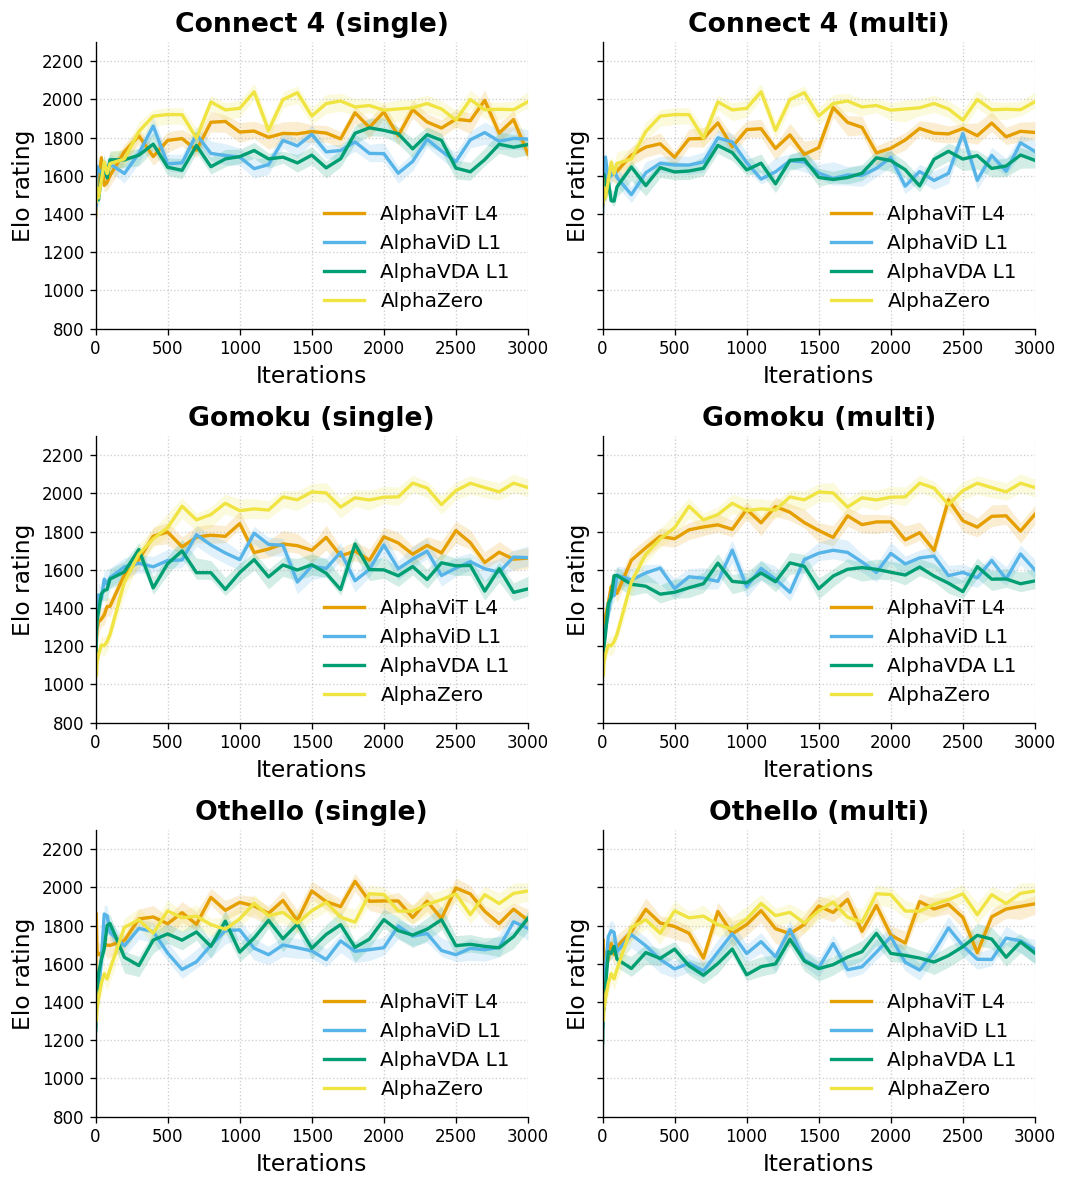

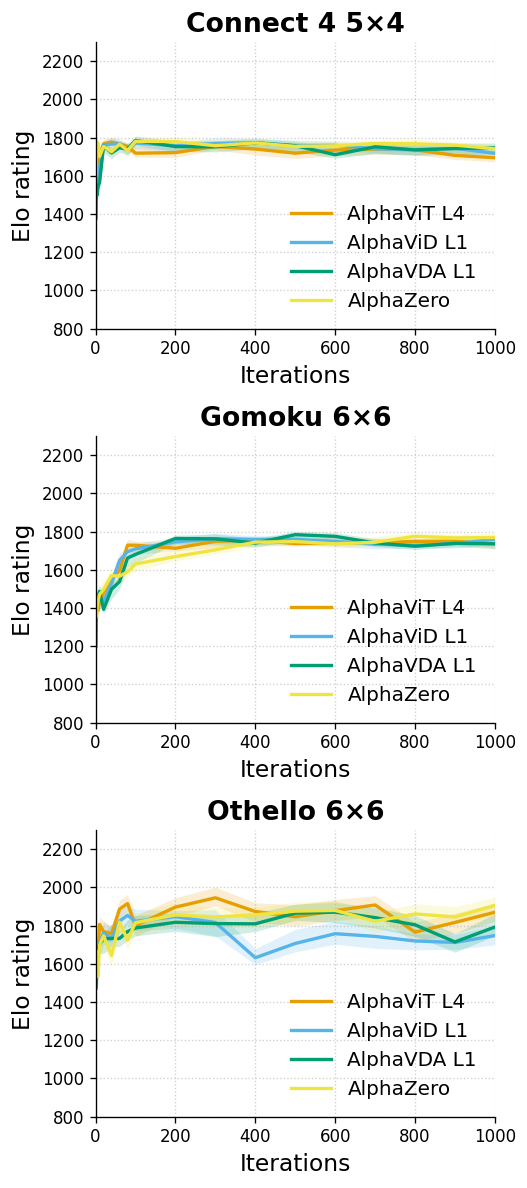

In [5]:
#!/usr/bin/env python3
"""
plot_elo.py – draw Elo-learning curves for Alpha-* agents.

* **Figure 1 – Large boards (6 panels, 3 × 2 grid)**
    ┌──────────────┬──────────────┐
    │ Connect4-single       │    Connect4-multi     │
    ├──────────────┼──────────────┤
    │ Gomoku-single  │ Gomoku-multi  │
    ├──────────────┼──────────────┤
    │ Othello-single │ Othello-multi │
    └──────────────┴──────────────┘
    Each panel shows 4 lines: AlphaViT / AlphaViD / AlphaVDA / AlphaZero.

* **Figure 2 – Small boards (3 panels)** remains unchanged.

95 %CI bands, Okabe-Ito colours, CLI `--data-root` そのまま。

Version 1.5 – arrange large-board figure in a 3 × 2 grid as requested.
"""
from __future__ import annotations
import argparse
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------------------------------------------------------------------------
# CLI arguments --------------------------------------------------------------
# ---------------------------------------------------------------------------

#parser = argparse.ArgumentParser(description="Plot Elo‑learning curves for Alpha‑* agents.")
#parser.add_argument("--data-root", default=".", help="Root directory that contains the six game sub‑folders (default: current directory)")
#args = parser.parse_args()

#DATA_ROOT: Path = Path(args.data_root).expanduser().resolve()
DATA_ROOT: Path = Path("./elo_over_iter").expanduser().resolve()


# ---------------------------------------------------------------------------
# Sub‑folder mapping ---------------------------------------------------------
# ---------------------------------------------------------------------------

game_dirs = {
    "Connect4": "Connect4",
    "Gomoku": "Gomoku",
    "Othello": "Othello",
    "Connect4 5×4": "Connect4_54",
    "Gomoku 6×6": "Gomoku66",
    "Othello 6×6": "Othello66",
}

# ---------------------------------------------------------------------------
# Configuration dictionaries -------------------------------------------------
# ---------------------------------------------------------------------------

LARGE_BOARDS_SPLIT = OrderedDict([
    ("Connect 4 (single)", {
        "dir": DATA_ROOT / game_dirs["Connect4"],
        "prefixes": {
            "AlphaViT_Large": "AlphaViT L4",
            "AlphaViD_Large": "AlphaViD L1",
            "AlphaVDA_Large": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Connect 4 (multi)", {
        "dir": DATA_ROOT / game_dirs["Connect4"],
        "prefixes": {
            "AlphaViT_Multi": "AlphaViT L4",
            "AlphaViD_Multi": "AlphaViD L1",
            "AlphaVDA_Multi": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Gomoku (single)", {
        "dir": DATA_ROOT / game_dirs["Gomoku"],
        "prefixes": {
            "AlphaViT_Large": "AlphaViT L4",
            "AlphaViD_Large": "AlphaViD L1",
            "AlphaVDA_Large": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Gomoku (multi)", {
        "dir": DATA_ROOT / game_dirs["Gomoku"],
        "prefixes": {
            "AlphaViT_Multi": "AlphaViT L4",
            "AlphaViD_Multi": "AlphaViD L1",
            "AlphaVDA_Multi": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Othello (single)", {
        "dir": DATA_ROOT / game_dirs["Othello"],
        "prefixes": {
            "AlphaViT_Large": "AlphaViT L4",
            "AlphaViD_Large": "AlphaViD L1",
            "AlphaVDA_Large": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Othello (multi)", {
        "dir": DATA_ROOT / game_dirs["Othello"],
        "prefixes": {
            "AlphaViT_Multi": "AlphaViT L4",
            "AlphaViD_Multi": "AlphaViD L1",
            "AlphaVDA_Multi": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
])

SMALL_BOARDS = OrderedDict([
    ("Connect 4 5×4", {
        "dir": DATA_ROOT / game_dirs["Connect4 5×4"],
        "prefixes": {
            "AlphaViT_Small": "AlphaViT L4",
            "AlphaViD_Small": "AlphaViD L1",
            "AlphaVDA_Small": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Gomoku 6×6", {
        "dir": DATA_ROOT / game_dirs["Gomoku 6×6"],
        "prefixes": {
            "AlphaViT_Small": "AlphaViT L4",
            "AlphaViD_Small": "AlphaViD L1",
            "AlphaVDA_Small": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
    ("Othello 6×6", {
        "dir": DATA_ROOT / game_dirs["Othello 6×6"],
        "prefixes": {
            "AlphaViT_Small": "AlphaViT L4",
            "AlphaViD_Small": "AlphaViD L1",
            "AlphaVDA_Small": "AlphaVDA L1",
            "AlphaZero": "AlphaZero",
        },
    }),
])

# ---------------------------------------------------------------------------
# Matplotlib style -----------------------------------------------------------
# ---------------------------------------------------------------------------

OKABE_ITO = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#000000",
]

mpl.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
})

# ---------------------------------------------------------------------------
# Helper functions -----------------------------------------------------------
# ---------------------------------------------------------------------------

def _load_curve(directory: Path, prefix: str) -> pd.DataFrame:
    """Load CSV for `prefix` and sort by iteration."""
    fpath = directory / f"{prefix}_Test_elos.csv"
    if not fpath.exists():
        raise FileNotFoundError(f"Expected file not found: {fpath}")
    return pd.read_csv(fpath).sort_values("iter")

# ---------------------------------------------------------------------------
# Plotting -------------------------------------------------------------------
# ---------------------------------------------------------------------------

def _plot_board_group(group_cfg: OrderedDict[str, dict], outfile: Path, *, is_small: bool) -> None:
    n_panels = len(group_cfg)
    if not is_small and n_panels == 6:
        rows, cols = 3, 2  # 3×2 grid for large boards
        figsize = (9, 10)
    else:
        rows, cols = 3, 1  # default vertical stack
        figsize = (4.5, 10)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=True)
    axes = np.array(axes).reshape(-1)  # flatten

    for ax, (board_name, cfg) in zip(axes, group_cfg.items()):
        palette = iter(OKABE_ITO)
        for prefix, label in cfg["prefixes"].items():
            colour = next(palette)
            df = _load_curve(cfg["dir"], prefix)
            x, y = df["iter"], df["elo"]
            ax.plot(x, y, label=label, color=colour, linewidth=2)
            if {"ci_low", "ci_high"}.issubset(df.columns):
                ax.fill_between(x, df["ci_low"], df["ci_high"], color=colour, alpha=0.18, linewidth=0)

        ax.set_title(board_name, fontweight="bold", fontsize=16)
        ax.set_ylabel("Elo rating", fontsize=14)
        ax.set_ylim(800, 2300)
        ax.set_xlim(0, 1000 if is_small else 3000)
        ax.set_xlabel("Iterations", fontsize=14)
        ax.legend(loc="lower right", fontsize=12, frameon=False)

    # turn off any leftover empty axes
    for ax in axes[len(group_cfg):]:
        ax.axis("off")

    fig.tight_layout()
    fig.savefig(outfile, bbox_inches="tight")
    print(f"✔ saved {outfile.relative_to(DATA_ROOT)}")

# ---------------------------------------------------------------------------
# Entry‑point ----------------------------------------------------------------
# ---------------------------------------------------------------------------

def main() -> None:
    _plot_board_group(LARGE_BOARDS_SPLIT, DATA_ROOT / "fig_large_boards.pdf", is_small=False)
    _plot_board_group(SMALL_BOARDS, DATA_ROOT / "fig_small_boards.pdf", is_small=True)


if __name__ == "__main__":
    main()


✔ saved fig_deeper_large_boards.pdf
✔ saved fig_deeper_small_boards.pdf


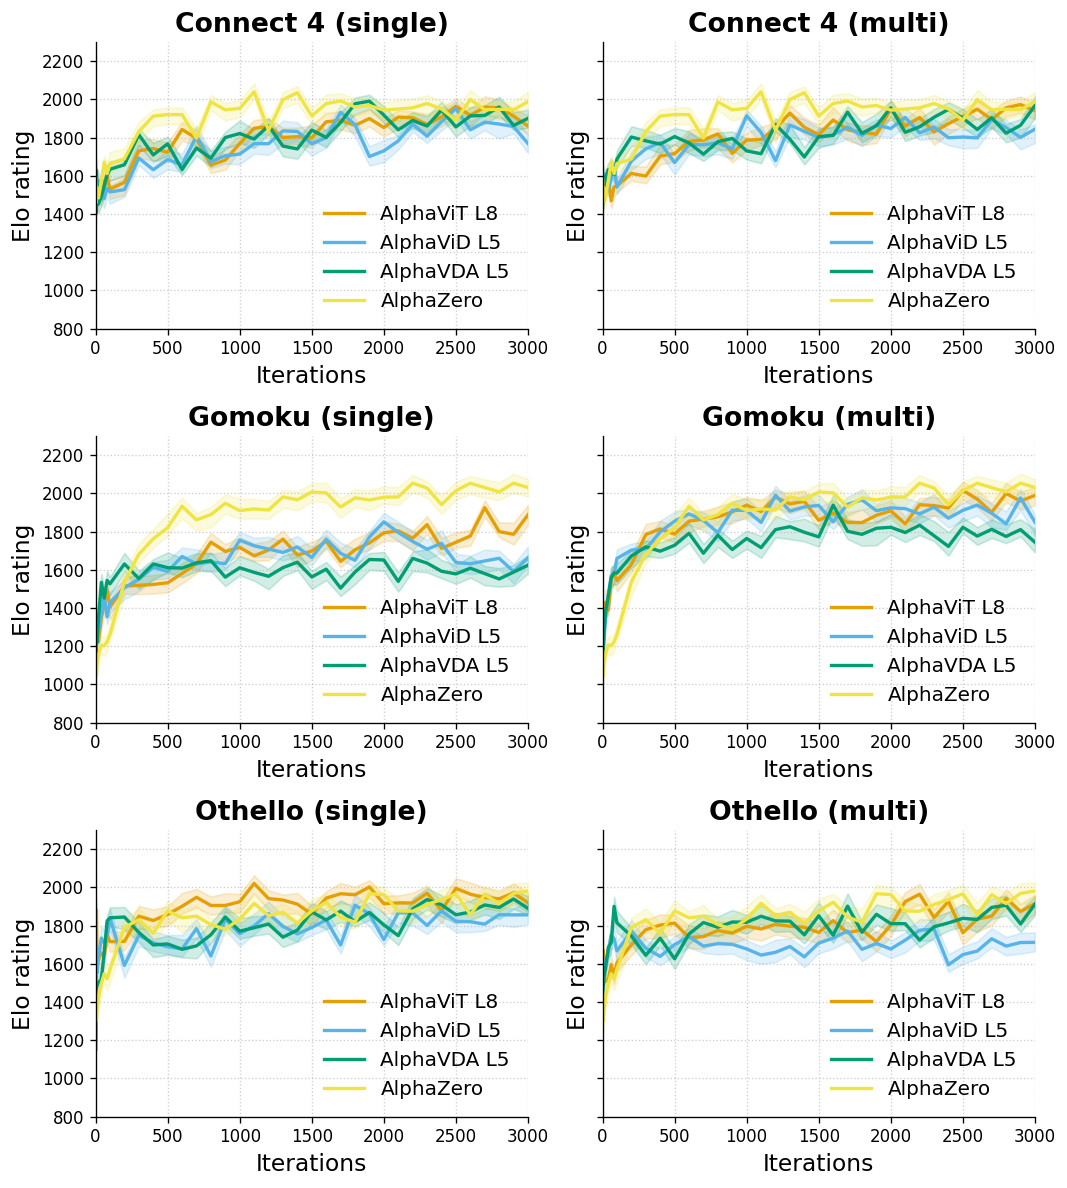

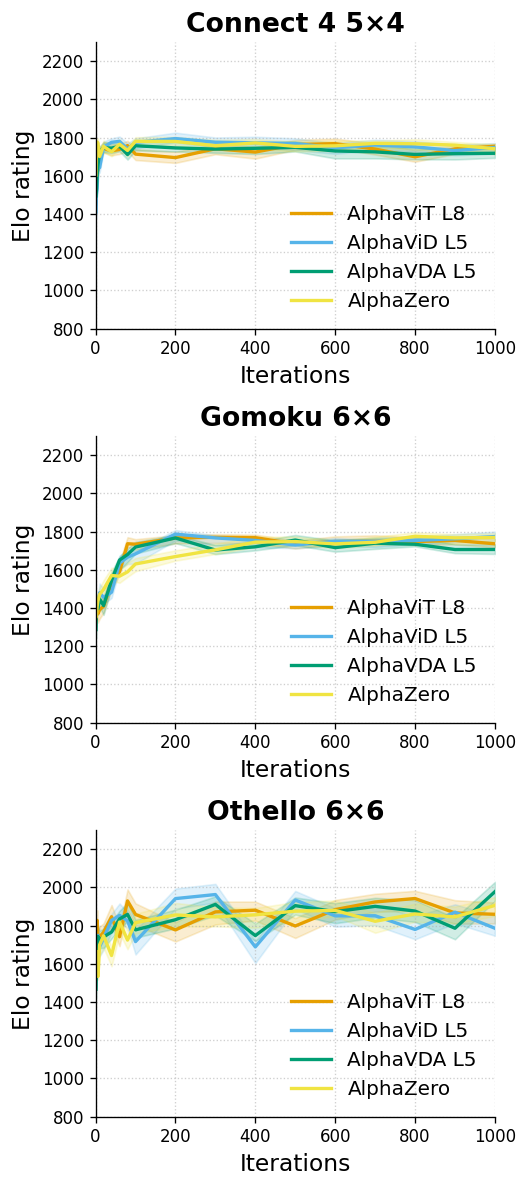

In [6]:
#!/usr/bin/env python3
"""
plot_elo.py – draw Elo-learning curves for Alpha-* agents.

* **Figure 1 – Large boards (6 panels, 3 × 2 grid)**
    ┌──────────────┬──────────────┐
    │ Connect4-single       │    Connect4-multi     │
    ├──────────────┼──────────────┤
    │ Gomoku-single  │ Gomoku-multi  │
    ├──────────────┼──────────────┤
    │ Othello-single │ Othello-multi │
    └──────────────┴──────────────┘
    Each panel shows 4 lines: AlphaViT / AlphaViD / AlphaVDA / AlphaZero.

* **Figure 2 – Small boards (3 panels)** remains unchanged.

95 %CI bands, Okabe-Ito colours, CLI `--data-root` そのまま。

Version 1.5 – arrange large-board figure in a 3 × 2 grid as requested.
"""
from __future__ import annotations
import argparse
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------------------------------------------------------------------------
# CLI arguments --------------------------------------------------------------
# ---------------------------------------------------------------------------

#parser = argparse.ArgumentParser(description="Plot Elo‑learning curves for Alpha‑* agents.")
#parser.add_argument("--data-root", default=".", help="Root directory that contains the six game sub‑folders (default: current directory)")
#args = parser.parse_args()

#DATA_ROOT: Path = Path(args.data_root).expanduser().resolve()
DEEP_ROOT    = Path("./elo_over_iter_deep").expanduser().resolve()
SHALLOW_ROOT = Path("./elo_over_iter").expanduser().resolve()
OUT_DIR      = Path(".")   # figure output

# ---------------------------------------------------------------------------
# Configuration dictionaries -------------------------------------------------
# ---------------------------------------------------------------------------

LARGE_BOARDS_SPLIT = OrderedDict([
    ("Connect 4 (single)", {
        "prefixes": [
            ("AlphaViT_Large", "AlphaViT L8",  DEEP_ROOT / "Connect4"),
            ("AlphaViD_Large", "AlphaViD L5",  DEEP_ROOT / "Connect4"),
            ("AlphaVDA_Large", "AlphaVDA L5",  DEEP_ROOT / "Connect4"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Connect4"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Connect4"),
        ]
    }),
    ("Connect 4 (multi)", {
        "prefixes": [
            ("AlphaViT_Multi", "AlphaViT L8",  DEEP_ROOT / "Connect4"),
            ("AlphaViD_Multi", "AlphaViD L5",  DEEP_ROOT / "Connect4"),
            ("AlphaVDA_Multi", "AlphaVDA L5",  DEEP_ROOT / "Connect4"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Connect4"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Connect4"),
        ]
    }),
    ("Gomoku (single)", {
        "prefixes": [
            ("AlphaViT_Large", "AlphaViT L8",  DEEP_ROOT / "Gomoku"),
            ("AlphaViD_Large", "AlphaViD L5",  DEEP_ROOT / "Gomoku"),
            ("AlphaVDA_Large", "AlphaVDA L5",  DEEP_ROOT / "Gomoku"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Gomoku"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Gomoku"),
        ]
    }),
    ("Gomoku (multi)", {
        "prefixes": [
            ("AlphaViT_Multi", "AlphaViT L8",  DEEP_ROOT / "Gomoku"),
            ("AlphaViD_Multi", "AlphaViD L5",  DEEP_ROOT / "Gomoku"),
            ("AlphaVDA_Multi", "AlphaVDA L5",  DEEP_ROOT / "Gomoku"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Gomoku"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Gomoku"),
        ]
    }),
    ("Othello (single)", {
        "prefixes": [
            ("AlphaViT_Large", "AlphaViT L8",  DEEP_ROOT / "Othello"),
            ("AlphaViD_Large", "AlphaViD L5",  DEEP_ROOT / "Othello"),
            ("AlphaVDA_Large", "AlphaVDA L5",  DEEP_ROOT / "Othello"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Othello"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Othello"),
        ]
    }),
    ("Othello (multi)", {
        "prefixes": [
            ("AlphaViT_Multi", "AlphaViT L8",  DEEP_ROOT / "Othello"),
            ("AlphaViD_Multi", "AlphaViD L5",  DEEP_ROOT / "Othello"),
            ("AlphaVDA_Multi", "AlphaVDA L5",  DEEP_ROOT / "Othello"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Othello"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Othello"),
        ]
    }),
])

SMALL_BOARDS = OrderedDict([
    ("Connect 4 5×4", {
        "prefixes": [
            ("AlphaViT_Small", "AlphaViT L8",  DEEP_ROOT / "Connect4_54"),
            ("AlphaViD_Small", "AlphaViD L5",  DEEP_ROOT / "Connect4_54"),
            ("AlphaVDA_Small", "AlphaVDA L5",  DEEP_ROOT / "Connect4_54"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Connect4_54"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Connect4_54"),
        ]
    }),
    ("Gomoku 6×6", {
        "prefixes": [
            ("AlphaViT_Small", "AlphaViT L8",  DEEP_ROOT / "Gomoku66"),
            ("AlphaViD_Small", "AlphaViD L5",  DEEP_ROOT / "Gomoku66"),
            ("AlphaVDA_Small", "AlphaVDA L5",  DEEP_ROOT / "Gomoku66"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Gomoku66"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Gomoku66"),
        ]
    }),
    ("Othello 6×6", {
        "prefixes": [
            ("AlphaViT_Small", "AlphaViT L8",  DEEP_ROOT / "Othello66"),
            ("AlphaViD_Small", "AlphaViD L5",  DEEP_ROOT / "Othello66"),
            ("AlphaVDA_Small", "AlphaVDA L5",  DEEP_ROOT / "Othello66"),
#            ("AlphaZero",      "Deeper AlphaZero", DEEP_ROOT / "Othello66"),
            ("AlphaZero",      "AlphaZero", SHALLOW_ROOT / "Othello66"),
        ]
    }),
])

# ---------------------------------------------------------------------------
# Matplotlib style -----------------------------------------------------------
# ---------------------------------------------------------------------------

OKABE_ITO = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#000000",
]

mpl.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
})

# ---------------------------------------------------------------------------
# Helper functions -----------------------------------------------------------
# ---------------------------------------------------------------------------
def _load_curve(directory: Path, prefix: str) -> pd.DataFrame:
    """Load CSV for `prefix` and sort by iteration."""
    fpath = directory / f"{prefix}_Test_elos.csv"
    if not fpath.exists():
        raise FileNotFoundError(f"Expected file not found: {fpath}")
    return pd.read_csv(fpath).sort_values("iter")

# ---------------------------------------------------------------------------
# Plotting -------------------------------------------------------------------
# ---------------------------------------------------------------------------

def _plot_board_group(cfg: OrderedDict[str, dict], outfile: Path, *, is_small: bool) -> None:
    n_panels = len(cfg)
    if not is_small and n_panels == 6:
        rows, cols = 3, 2  # 3×2 grid for large boards
        figsize = (9, 10)
    else:
        rows, cols = 3, 1  # default vertical stack
        figsize = (4.5, 10)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=True)
    axes = np.array(axes).reshape(-1)  # flatten

    for ax, (title, board) in zip(axes, cfg.items()):
        palette = iter(OKABE_ITO)
        for prefix, label, droot in board["prefixes"]:
            color = next(palette)
            df = _load_curve(droot, prefix)
            ax.plot(df["iter"], df["elo"], label=label, color=color, lw=2)
            if {"ci_low", "ci_high"}.issubset(df.columns):
                ax.fill_between(df["iter"], df["ci_low"], df["ci_high"], color=color, alpha=0.18)

        ax.set_title(title, fontweight="bold", fontsize=16)
        ax.set_ylabel("Elo rating", fontsize=14)
        ax.set_ylim(800, 2300)
        ax.set_xlim(0, 1000 if is_small else 3000)
        ax.set_xlabel("Iterations", fontsize=14)
        ax.legend(loc="lower right", fontsize=12, frameon=False)

    # turn off any leftover empty axes
    for ax in axes[len(cfg):]:
        ax.axis("off")

    fig.tight_layout()
    fig.savefig(outfile, bbox_inches="tight")
    print(f"✔ saved {outfile.relative_to(DEEP_ROOT)}")

# ---------------------------------------------------------------------------
# Entry‑point ----------------------------------------------------------------
# ---------------------------------------------------------------------------

def main() -> None:
    _plot_board_group(LARGE_BOARDS_SPLIT, DEEP_ROOT / "fig_deeper_large_boards.pdf", is_small=False)
    _plot_board_group(SMALL_BOARDS, DEEP_ROOT / "fig_deeper_small_boards.pdf", is_small=True)


if __name__ == "__main__":
    main()


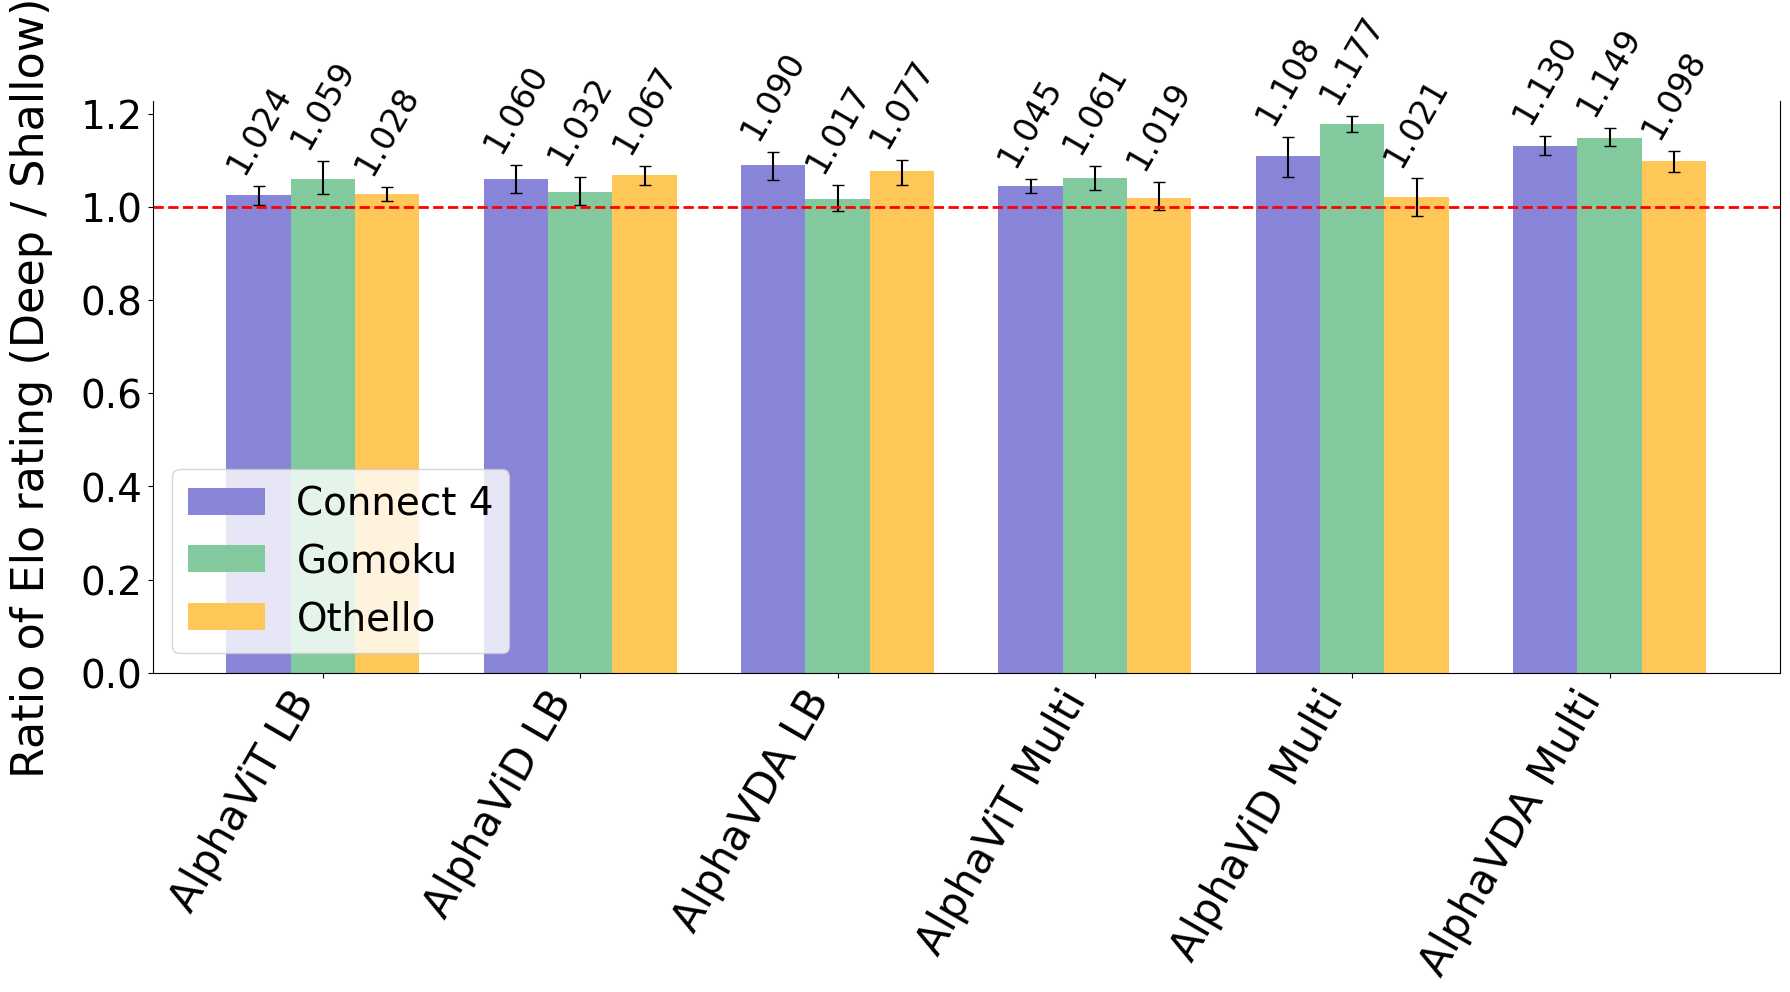

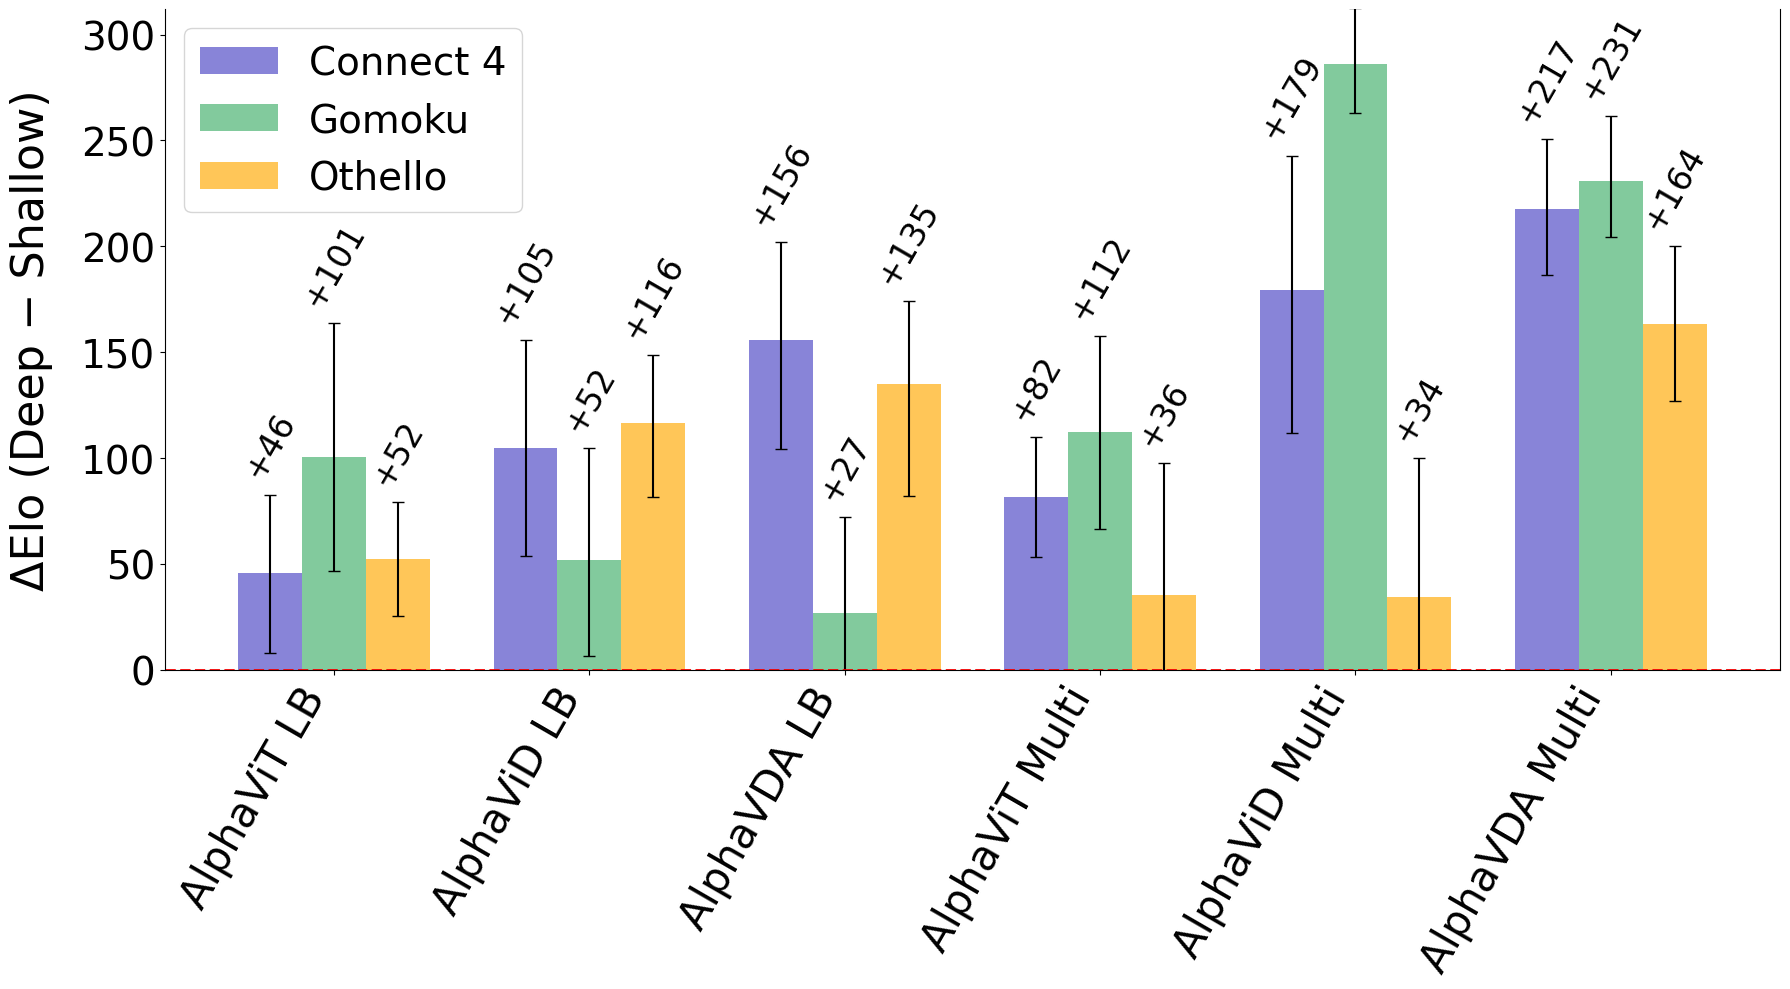

✓ 2 つの PDF を保存しました → ratio_with_CI.pdf / delta_with_CI.pdf


In [1]:
#!/usr/bin/env python
# ───────────────────────────────────────────────────────────
#  • 2100–3000 it 区間の Deep/Shallow 平均比 & ΔElo を
#    95 % ブートストラップ CI 付きで描画
#  • Figure-6 と同じ並び・色・フォントを維持しつつ
#    数値ラベルがエラーバーと重ならないように調整
# ───────────────────────────────────────────────────────────
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ───── ユーザ設定 ──────────────────────────────────────────
CSV      = Path("deep_vs_shallow_boot.csv")      # 集計済み CSV
MODELS   = ['AlphaViT LB', 'AlphaViD LB', 'AlphaVDA LB',
            'AlphaViT Multi', 'AlphaViD Multi', 'AlphaVDA Multi']
GAMES    = ['Connect4', 'Gomoku', 'Othello']
COLORS   = ['#8884d8', '#82ca9d', '#ffc658']     # 紫・緑・黄
WIDTH    = 0.25                                   # 棒 1 本の幅
LABEL_FS = 24                                     # 値ラベルのフォント
AXIS_FS  = 32                                     # 軸フォント
LEG_FS   = 28                                     # 凡例フォント
ERR_LW   = 1.5                                    # エラーバー線幅
OFFSET_RATIO = 0.015                              # 比グラフ用余白
OFFSET_DELTA = 5                                  # ΔElo グラフ用余白

# ───── CSV 読み込み & 整形 ────────────────────────────────
df = pd.read_csv(CSV)

# Shallow 名 "AlphaViT L4 LB" → ベース名 "AlphaViT LB"
df["Model"] = df["Shallow"].str.replace(r" L\d+ ", " ", regex=True).str.strip()

# dict 構造に格納
metric, lo, hi = {}, {}, {}
for kind, mean_col, lo_col, hi_col in [
    ('ratio', 'Mean_ratio',  'Ratio_CI_low',  'Ratio_CI_high'),
    ('delta', 'Mean_delta',  'Delta_CI_low',  'Delta_CI_high')
]:
    metric[kind], lo[kind], hi[kind] = {g: [] for g in GAMES}, {g: [] for g in GAMES}, {g: [] for g in GAMES}
    for g in GAMES:
        sub = df[df['Game'] == g]
        for m in MODELS:
            row = sub[sub['Model'] == m]
            if row.empty:
                metric[kind][g].append(np.nan); lo[kind][g].append(np.nan); hi[kind][g].append(np.nan)
            else:
                r = row.iloc[0]
                metric[kind][g].append(r[mean_col])
                lo[kind][g].append(r[mean_col] - r[lo_col])
                hi[kind][g].append(r[hi_col] - r[mean_col])

# ───── 描画ヘルパ ─────────────────────────────────────────
def add_labels(bars, err_hi, fmt, offset):
    """バーごとに値ラベルを（エラーバー先端＋offset）へ配置"""
    for bar, e in zip(bars, err_hi):
        h = bar.get_height()
        ypos = h + e + offset
        txt = fmt.format(h)
        plt.annotate(txt,
                     xy=(bar.get_x() + bar.get_width()/2, ypos),
                     xytext=(0, 0), textcoords='offset points',
                     ha='center', va='bottom',
                     fontsize=LABEL_FS, rotation=60)

def plot_panel(kind, ylabel, hline, offset, out_pdf):
    fig, ax = plt.subplots(figsize=(18, 10))
    x = np.arange(len(MODELS))
    offsets = [-WIDTH, 0, WIDTH]

    for idx, (g, col) in enumerate(zip(GAMES, COLORS)):
        display_label = g.replace('Connect4', 'Connect 4')
        y   = metric[kind][g]
        err = np.vstack([lo[kind][g], hi[kind][g]])
        bars = ax.bar(x + offsets[idx], y, WIDTH,
                      label=display_label, color=col,
                      yerr=err, capsize=4,
                      error_kw={'elinewidth': ERR_LW})

        fmt = '{:.3f}' if kind == 'ratio' else '{:+.0f}'
        add_labels(bars, hi[kind][g], fmt, offset)

    # 軸・装飾
    ax.set_ylabel(ylabel, fontsize=AXIS_FS, labelpad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(MODELS, rotation=60, ha='right', fontsize=AXIS_FS-2)
    ax.tick_params(axis='y', labelsize=AXIS_FS-4)
    ax.legend(fontsize=LEG_FS)
    ax.axhline(hline, color='r', linestyle='--', linewidth=2)

    # y 範囲に少し余裕
    all_vals = np.concatenate([metric[kind][g] for g in GAMES])
    ymax = np.nanmax(all_vals); ymin = np.nanmin(all_vals)
    fudge = 0.05 if kind == 'ratio' else 0.1 * (ymax-ymin)
    #ax.set_ylim(ymin - fudge, ymax + fudge)
    ax.set_ylim(0, ymax + fudge)
      
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches='tight')
    plt.show()

# ───── 図を生成 ──────────────────────────────────────────
plot_panel('ratio',
           ylabel='Ratio of Elo rating (Deep / Shallow)',
           hline=1,
           offset=OFFSET_RATIO,
           out_pdf='ratio_with_CI.pdf')

plot_panel('delta',
           ylabel='ΔElo (Deep − Shallow)',
           hline=0,
           offset=OFFSET_DELTA,
           out_pdf='delta_with_CI.pdf')

print("✓ 2 つの PDF を保存しました → ratio_with_CI.pdf / delta_with_CI.pdf")


✔  elo_shallower_deeper.pdf を保存しました


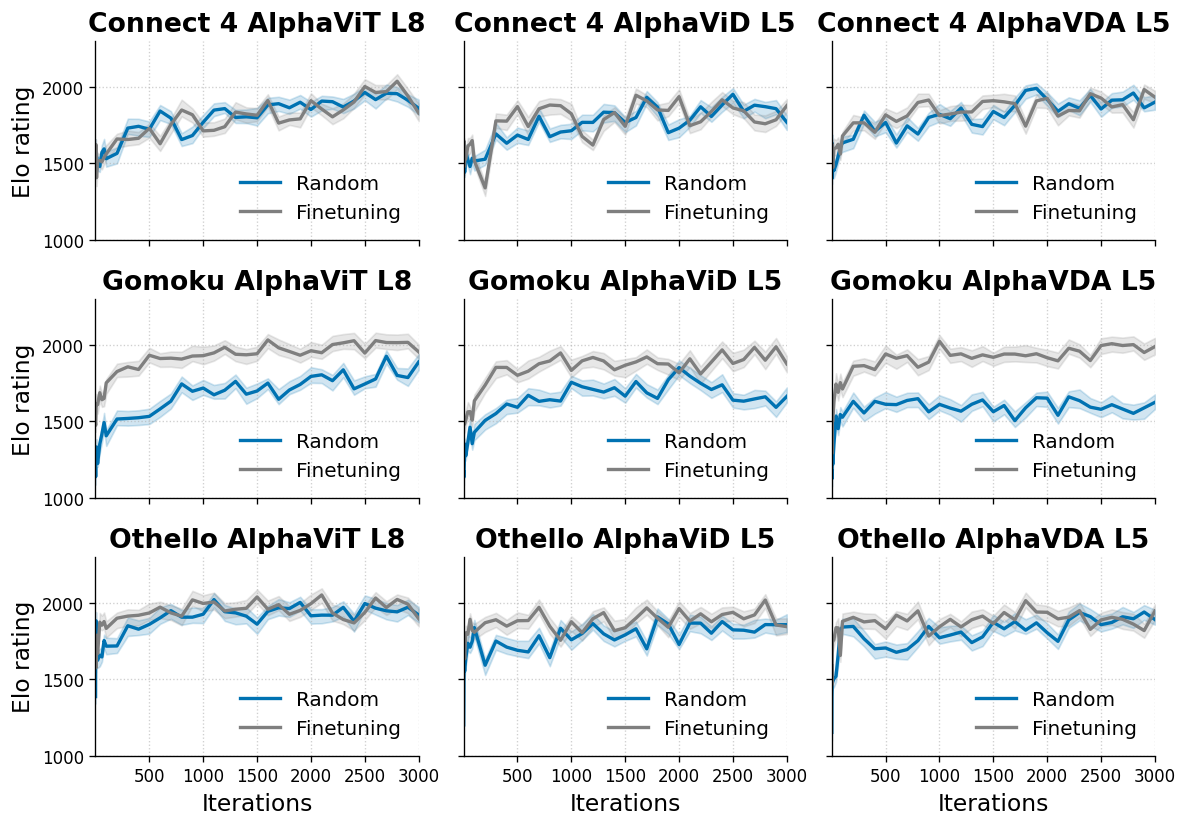

In [2]:
#!/usr/bin/env python3
"""
plot_elo_ci95.py – 3×3 マルチパネルで Elo 学習曲線を描画（CI95 付き）

● 入力  : *.csv* あるいは *.dat* 形式  
           列順 = iteration, elo, ci_low, ci_high   （区切りは空白でも , でも可）
● 出力  : Fig7_matplotlib.png（300 dpi）と同 PDF
● 依存  : pandas, matplotlib 3.8+, numpy
"""

from __future__ import annotations
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# -------------------------- スタイル -----------------------------------------
OKABE_ITO = [
    "#0072B2", "#7f7f7f", "#ff7f0e",
    "#56B4E9", "#4D4D4D", "#FDB863", "#F0E442"
]

mpl.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
})

# ----------------------- パネル定義（必要に応じて編集） ------------------------
PANELS: list[tuple[str, list[tuple[str, str]]]] = [
    # title, [(path, label), ...]     ←色は自動で回ります
    ("Connect 4 AlphaViT L8", [
        ("elo_over_iter_deep/Connect4/AlphaViT_Large_Test_elos.csv",      "Random"),
        ("elo_over_iter_finetuning_deep/Connect4/AlphaViT_Large_Test_elos.csv", "Finetuning"),
    ]),
    ("Connect 4 AlphaViD L5", [
        ("elo_over_iter_deep/Connect4/AlphaViD_Large_Test_elos.csv",      "Random"),
        ("elo_over_iter_finetuning_deep/Connect4/AlphaViD_Large_Test_elos.csv", "Finetuning"),
    ]),
    ("Connect 4 AlphaVDA L5", [
        ("elo_over_iter_deep/Connect4/AlphaVDA_Large_Test_elos.csv",      "Random"),
        ("elo_over_iter_finetuning_deep/Connect4/AlphaVDA_Large_Test_elos.csv", "Finetuning"),
    ]),

    ("Gomoku AlphaViT L8", [
        ("elo_over_iter_deep/Gomoku/AlphaViT_Large_Test_elos.csv",        "Random"),
        ("elo_over_iter_finetuning_deep/Gomoku/AlphaViT_Large_Test_elos.csv",   "Finetuning"),
    ]),
    ("Gomoku AlphaViD L5", [
        ("elo_over_iter_deep/Gomoku/AlphaViD_Large_Test_elos.csv",        "Random"),
        ("elo_over_iter_finetuning_deep/Gomoku/AlphaViD_Large_Test_elos.csv",   "Finetuning"),
    ]),
    ("Gomoku AlphaVDA L5", [
        ("elo_over_iter_deep/Gomoku/AlphaVDA_Large_Test_elos.csv",        "Random"),
        ("elo_over_iter_finetuning_deep/Gomoku/AlphaVDA_Large_Test_elos.csv",   "Finetuning"),
    ]),

    ("Othello AlphaViT L8", [
        ("elo_over_iter_deep/Othello/AlphaViT_Large_Test_elos.csv",       "Random"),
        ("elo_over_iter_finetuning_deep/Othello/AlphaViT_Large_Test_elos.csv",  "Finetuning"),
    ]),
    ("Othello AlphaViD L5", [
        ("elo_over_iter_deep/Othello/AlphaViD_Large_Test_elos.csv",       "Random"),
        ("elo_over_iter_finetuning_deep/Othello/AlphaViD_Large_Test_elos.csv",  "Finetuning"),
    ]),
    ("Othello AlphaVDA L5", [
        ("elo_over_iter_deep/Othello/AlphaVDA_Large_Test_elos.csv",       "Random"),
        ("elo_over_iter_finetuning_deep/Othello/AlphaVDA_Large_Test_elos.csv",  "Finetuning"),
    ]),
]

# --------------------------- ヘルパー ----------------------------------------
def load_curve(path: str) -> pd.DataFrame:
    """
    iteration, elo, ci_low, ci_high を読み込んで iteration 昇順に並べ替え
    - .csv はカンマ区切り・ヘッダ付き
    - .dat は可変長空白区切りでヘッダ無し（必要なら適宜変更）
    """
    if path.endswith(".csv"):
        df = pd.read_csv(path)                    # ヘッダ自動認識, sep="," デフォルト
    else:
        df = pd.read_csv(path,
                         sep=r"\s+",
                         header=None,
                         names=["iter", "elo", "ci_low", "ci_high"],
                         engine="python")
    return df.sort_values("iter")

# ---------------------------- メイン -----------------------------------------
def main() -> None:
    fig, axes = plt.subplots(3, 3, figsize=(10, 7), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, (ax, (title, series)) in enumerate(zip(axes, PANELS)):
        row, col = divmod(idx, 3)      # ← 追加：3×3 グリッドの行・列
        for (file_path, label), color in zip(series, OKABE_ITO):
            df = load_curve(file_path)
            ax.plot(df["iter"], df["elo"], label=label, lw=2, color=color)
            ax.fill_between(df["iter"], df["ci_low"], df["ci_high"],
                            color=color, alpha=0.18)
        ax.set_title(title, fontsize=16, fontweight="bold")
        ax.set_xlim(0, 3000)
        ax.set_ylim(1000, 2300)
        ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000])
        if col == 0:                   # ← 変更：is_first_col() の代替
            ax.set_ylabel("Elo rating", fontsize=14)
        if row == 2:                   # ← 変更：is_last_row() の代替
            ax.set_xlabel("Iterations", fontsize=14)
        ax.legend(loc="lower right", fontsize=12, frameon=False)

    fig.tight_layout()
    #fig.savefig("elo_shallower_deeper.png", dpi=300)
    fig.savefig("elo_shallower_deeper.pdf")
    print("✔  elo_shallower_deeper.pdf を保存しました")

if __name__ == "__main__":
    main()


✔  elo_alphazero_res10.pdf を保存しました


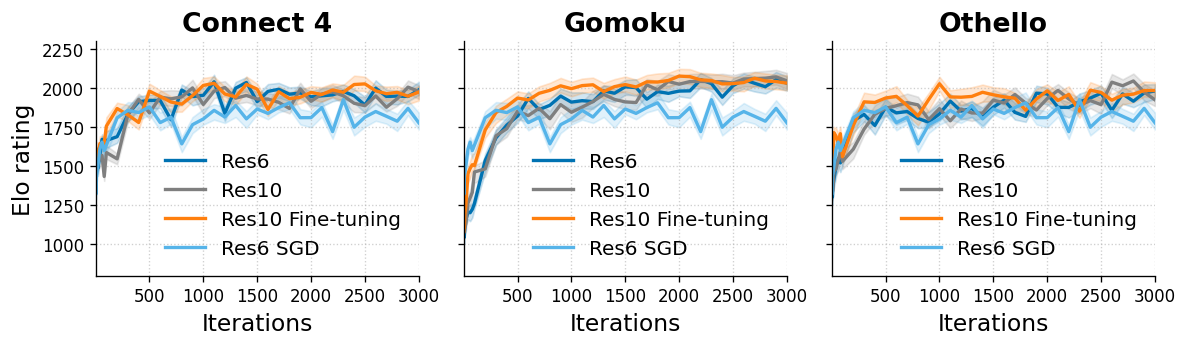

In [5]:
#!/usr/bin/env python3
"""
plot_elo_ci95.py – 3×3 マルチパネルで Elo 学習曲線を描画（CI95 付き）

● 入力  : *.csv* あるいは *.dat* 形式  
           列順 = iteration, elo, ci_low, ci_high   （区切りは空白でも , でも可）
● 出力  : Fig7_matplotlib.png（300 dpi）と同 PDF
● 依存  : pandas, matplotlib 3.8+, numpy
"""

from __future__ import annotations
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# -------------------------- スタイル -----------------------------------------
OKABE_ITO = [
    "#0072B2", "#7f7f7f", "#ff7f0e",
    "#56B4E9", "#4D4D4D", "#FDB863", "#F0E442"
]

mpl.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
})

# ----------------------- パネル定義（必要に応じて編集） ------------------------
PANELS: list[tuple[str, list[tuple[str, str]]]] = [
    # title, [(path, label), ...]     ←色は自動で回ります
    ("Connect 4", [
        ("elo_over_iter/Connect4/AlphaZero_Test_elos.csv",      "Res6"),
        ("elo_over_iter_deep/Connect4/AlphaZero_Test_elos.csv",      "Res10"),
        ("elo_over_iter_finetuning_deep/Connect4/AlphaZero_Test_elos.csv", "Res10 Fine-tuning"),
        ("elo_over_iter/Othello/AlphaZero_SGD_Test_elos.csv",             "Res6 SGD"),
    ]),

    ("Gomoku", [
        ("elo_over_iter/Gomoku/AlphaZero_Test_elos.csv",             "Res6"),
        ("elo_over_iter_deep/Gomoku/AlphaZero_Test_elos.csv",             "Res10"),
        ("elo_over_iter_finetuning_deep/Gomoku/AlphaZero_Test_elos.csv",   "Res10 Fine-tuning"),
        ("elo_over_iter/Othello/AlphaZero_SGD_Test_elos.csv",             "Res6 SGD"),
    ]),

    ("Othello", [
        ("elo_over_iter/Othello/AlphaZero_Test_elos.csv",             "Res6"),
        ("elo_over_iter_deep/Othello/AlphaZero_Test_elos.csv",       "Res10"),
        ("elo_over_iter_finetuning_deep/Othello/AlphaZero_Test_elos.csv",  "Res10 Fine-tuning"),
        ("elo_over_iter/Othello/AlphaZero_SGD_Test_elos.csv",             "Res6 SGD"),
    ]),
]

# --------------------------- ヘルパー ----------------------------------------
def load_curve(path: str) -> pd.DataFrame:
    """
    iteration, elo, ci_low, ci_high を読み込んで iteration 昇順に並べ替え
    - .csv はカンマ区切り・ヘッダ付き
    - .dat は可変長空白区切りでヘッダ無し（必要なら適宜変更）
    """
    if path.endswith(".csv"):
        df = pd.read_csv(path)                    # ヘッダ自動認識, sep="," デフォルト
    else:
        df = pd.read_csv(path,
                         sep=r"\s+",
                         header=None,
                         names=["iter", "elo", "ci_low", "ci_high"],
                         engine="python")
    return df.sort_values("iter")

# ---------------------------- メイン -----------------------------------------
def main() -> None:
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, (ax, (title, series)) in enumerate(zip(axes, PANELS)):
        row, col = divmod(idx, 3)      # ← 追加：3×3 グリッドの行・列
        for (file_path, label), color in zip(series, OKABE_ITO):
            df = load_curve(file_path)
            ax.plot(df["iter"], df["elo"], label=label, lw=2, color=color)
            ax.fill_between(df["iter"], df["ci_low"], df["ci_high"],
                            color=color, alpha=0.18)
        ax.set_title(title, fontsize=16, fontweight="bold")
        ax.set_xlim(0, 3000)
        ax.set_ylim(800, 2300)
        ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000])
        if col == 0:                   # ← 変更：is_first_col() の代替
            ax.set_ylabel("Elo rating", fontsize=14)
        ax.set_xlabel("Iterations", fontsize=14)
        ax.legend(loc="lower right", fontsize=12, frameon=False)

    fig.tight_layout()
    fig.savefig("elo_alphazero_res10.pdf")
    print("✔  elo_alphazero_res10.pdf を保存しました")

if __name__ == "__main__":
    main()


✔  elo_alphazerogp.pdf を保存しました


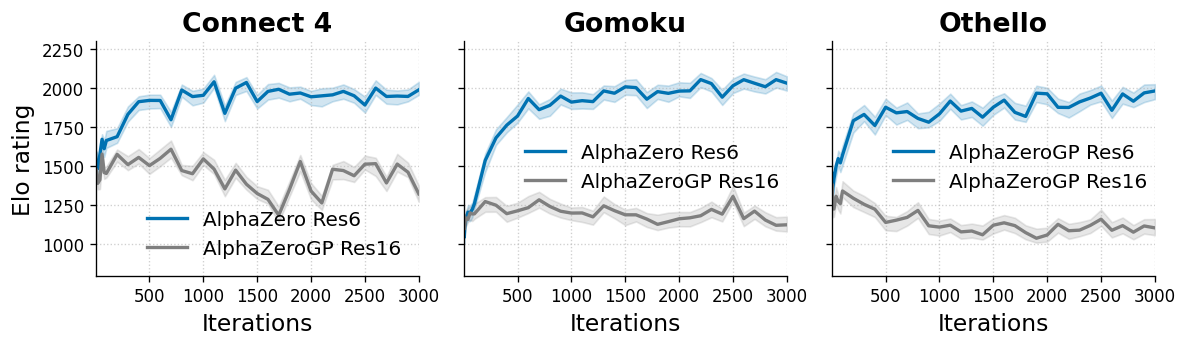

In [6]:
#!/usr/bin/env python3
"""
plot_elo_ci95.py – 3×3 マルチパネルで Elo 学習曲線を描画（CI95 付き）

● 入力  : *.csv* あるいは *.dat* 形式  
           列順 = iteration, elo, ci_low, ci_high   （区切りは空白でも , でも可）
● 出力  : Fig7_matplotlib.png（300 dpi）と同 PDF
● 依存  : pandas, matplotlib 3.8+, numpy
"""

from __future__ import annotations
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# -------------------------- スタイル -----------------------------------------
OKABE_ITO = [
    "#0072B2", "#7f7f7f", "#ff7f0e",
    "#56B4E9", "#4D4D4D", "#FDB863", "#F0E442"
]

mpl.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
})

# ----------------------- パネル定義（必要に応じて編集） ------------------------
PANELS: list[tuple[str, list[tuple[str, str]]]] = [
    # title, [(path, label), ...]     ←色は自動で回ります
    ("Connect 4", [
        ("elo_over_iter/Connect4/AlphaZero_Test_elos.csv",      "AlphaZero Res6"),
        ("elo_over_iter_deep/Connect4/AlphaZeroGP_Test_elos.csv",      "AlphaZeroGP Res16"),
    ]),

    ("Gomoku", [
        ("elo_over_iter/Gomoku/AlphaZero_Test_elos.csv",             "AlphaZero Res6"),
        ("elo_over_iter_deep/Gomoku/AlphaZeroGP_Test_elos.csv",             "AlphaZeroGP Res16"),
    ]),

    ("Othello", [
        ("elo_over_iter/Othello/AlphaZero_Test_elos.csv",             "AlphaZeroGP Res6"),
        ("elo_over_iter_deep/Othello/AlphaZeroGP_Test_elos.csv",       "AlphaZeroGP Res16"),
    ]),
]

# --------------------------- ヘルパー ----------------------------------------
def load_curve(path: str) -> pd.DataFrame:
    """
    iteration, elo, ci_low, ci_high を読み込んで iteration 昇順に並べ替え
    - .csv はカンマ区切り・ヘッダ付き
    - .dat は可変長空白区切りでヘッダ無し（必要なら適宜変更）
    """
    if path.endswith(".csv"):
        df = pd.read_csv(path)                    # ヘッダ自動認識, sep="," デフォルト
    else:
        df = pd.read_csv(path,
                         sep=r"\s+",
                         header=None,
                         names=["iter", "elo", "ci_low", "ci_high"],
                         engine="python")
    return df.sort_values("iter")

# ---------------------------- メイン -----------------------------------------
def main() -> None:
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, (ax, (title, series)) in enumerate(zip(axes, PANELS)):
        row, col = divmod(idx, 3)      # ← 追加：3×3 グリッドの行・列
        for (file_path, label), color in zip(series, OKABE_ITO):
            df = load_curve(file_path)
            ax.plot(df["iter"], df["elo"], label=label, lw=2, color=color)
            ax.fill_between(df["iter"], df["ci_low"], df["ci_high"],
                            color=color, alpha=0.18)
        ax.set_title(title, fontsize=16, fontweight="bold")
        ax.set_xlim(0, 3000)
        ax.set_ylim(800, 2300)
        ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000])
        if col == 0:                   # ← 変更：is_first_col() の代替
            ax.set_ylabel("Elo rating", fontsize=14)
        ax.set_xlabel("Iterations", fontsize=14)
        # Othello（idx==2 または title=="Othello"）だけ上にずらす
        if title == "Othello":
            # upper right の少し下に出す例
            ax.legend(
                loc="upper right",
                bbox_to_anchor=(1.0, 0.6),
                borderaxespad=0,
                fontsize=12,
                frameon=False,
            )
        elif title == "Gomoku":
            # upper right の少し下に出す例
            ax.legend(
                loc="upper right",
                bbox_to_anchor=(1.0, 0.6),
                borderaxespad=0,
                fontsize=12,
                frameon=False,
            )
        else:
            ax.legend(loc="lower right", fontsize=12, frameon=False)

    fig.tight_layout()
    fig.savefig("elo_alphazerogp.pdf")
    print("✔  elo_alphazerogp.pdf を保存しました")

if __name__ == "__main__":
    main()
